In [1]:
# Importamos las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import networkx as nx
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import gudhi as gd
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud

# Limpieza de Datos

In [2]:
# Cargamos la base de datos
pkl = pd.read_pickle('uke_eggedal_data_challenge.pkl')
pkl

{'flow': array([1.72378057e+00, 9.60881602e-01, 1.00000000e-03, ...,
        3.55681843e+00, 3.40213266e+00, 1.81279569e+00]),
 'obs_tas': array([[-10.60000038,  -9.69999981,  -6.69999981, ...,  -8.10000038,
          -6.5       ,  -5.4000001 ],
        [-20.5       , -19.10000038, -12.        , ..., -15.5       ,
         -11.80000019,  -9.10000038],
        [-23.60000038, -22.5       , -15.10000038, ..., -19.39999962,
         -14.60000038, -12.19999981],
        ...,
        [-11.89999962, -11.39999962,  -8.39999962, ...,  -9.30000019,
          -7.19999981,  -6.30000019],
        [ -7.        ,  -6.5       ,  -3.4000001 , ...,  -5.        ,
          -3.79999995,  -3.        ],
        [ -2.4000001 ,  -2.0999999 ,   1.29999995, ...,  -0.89999998,
           0.5       ,   1.10000002]]),
 'flow_dates': 1958-01-04   1958-01-04
 1958-01-05   1958-01-05
 1958-01-06   1958-01-06
 1958-01-07   1958-01-07
 1958-01-08   1958-01-08
                 ...    
 2016-12-22   2016-12-22
 2016-12-2

In [3]:
# Registros por columna
for i in pkl.keys():
    print(i, len(pkl[i]))

flow 21542
obs_tas 21546
flow_dates 21542
obs_lon_lat 2
obs_pr 21546
obs_dates 21546


In [4]:
# Formateamos el data frame
df1 = pd.DataFrame(pkl['flow'])
df1.columns = ['flow']

df2 = pd.DataFrame(pkl['obs_tas'])
df2.columns = ['tas_0', 'tas_1', 'tas_2', 'tas_3', 'tas_4', 'tas_5', 'tas_6', 'tas_7', 'tas_8']

df3 = pd.DataFrame(pkl['flow_dates'])
df3.columns = ['flow_dates']

df4 = pd.DataFrame(pkl['obs_pr'])
df4.columns = ['pr_0', 'pr_1', 'pr_2', 'pr_3', 'pr_4', 'pr_5', 'pr_6', 'pr_7', 'pr_8']

df5 = pd.DataFrame(pkl['obs_dates'])
df5.columns = ['dates']

In [5]:
# Ajustamos el indice a las fechas con las que contamos
df = pd.concat([df1, df2, df4], axis=1, join='inner')
df.index = df3.index
df = pd.concat([df, df5], axis=1, join='inner')
df

flow      tas_0  tas_1  tas_2      tas_3      tas_4  \
1958-01-04  1.723781 -10.600000   -9.7   -6.7  -8.800000  -8.900000   
1958-01-05  0.960882 -20.500000  -19.1  -12.0 -17.700001 -17.700001   
1958-01-06  0.001000 -23.600000  -22.5  -15.1 -21.400000 -21.400000   
1958-01-07  0.001000 -16.200001  -16.0  -14.1 -15.600000 -15.400000   
1958-01-08  0.316796  -7.900000   -7.8   -9.5  -7.600000  -7.500000   
...              ...        ...    ...    ...        ...        ...   
2015-12-27  2.177040 -10.300000  -10.6  -13.8 -11.300000 -10.600000   
2015-12-28  4.876250 -14.700000  -15.1  -15.7 -16.000000 -15.200000   
2015-12-29  4.998840  -9.500000   -8.9  -11.0  -9.700000  -9.200000   
2015-12-30  4.428777  -2.000000   -1.2   -4.2   0.000000  -0.500000   
2015-12-31  4.047925   3.300000    4.0    4.5   4.900000   4.600000   

                tas_5  tas_6  tas_7  tas_8  pr_0  pr_1  pr_2  pr_3  pr_4  \
1958-01-04  -7.500000   -8.1   -6.5   -5.4   0.0   0.0   0.0   0.0   0.0   
1958-01-05 -13.100000  -15.5  -11.8   -9.1   0.0   0.0   0.0   0.0   0.0   
1958-01-06 -16.299999  -19.4  -14.6  -12.2   0.1   0.0   0.3   0.1   0.3   
1958-01-07 -14.500000  -15.0  -13.8  -11.9   1.0   0.0   1.0   1.1   0.9   
1958-01-08  -8.000000   -7.4   -8.6   -8.2   9.3   8.6   8.0   8.9   8.7   
...               ...    ...    ...    ...   ...   ...   ...   ...   ...   
2015-12-27 -11.800000  -11.4  -12.2  -12.5   0.0   0.0   0.0   0.0   0.0   
2015-12-28 -13.700000  -15.4  -13.9  -13.5   0.0   0.0   0.0   0.0   0.0   
2015-12-29  -9.600000   -9.3  -10.3  -10.3   0.5   0.1   1.0   0.5   0.3   
2015-12-30  -1.000000    0.4   -3.2   -4.9   0.0   0.0   0.0   0.0   0.0   
2015-12-31   4.500000    5.4    4.0    2.8   1.0   1.4   0.4   0.4   0.7   

            pr_5  pr_6  pr_7  pr_8      dates  
1958-01-04   0.0   0.0   0.1   0.1 1958-01-04  
1958-01-05   0.0   0.0   0.2   0.1 1958-01-05  
1958-01-06   0.3   0.4   0.3   0.5 1958-01-06  
1958-01-07   0.7   0.8   0.4   0.6 1958-01-07  
1958-01-08  10.2   9.3  10.1   9.7 1958-01-08  
...          ...   ...   ...   ...        ...  
2015-12-27   0.0   0.0   0.0   0.0 2015-12-27  
2015-12-28   0.0   0.0   0.0   0.0 2015-12-28  
2015-12-29   0.1   0.8   0.0   0.0 2015-12-29  
2015-12-30   0.0   0.0   0.0   0.0 2015-12-30  
2015-12-31   0.0   0.0   0.0   0.0 2015-12-31  

[21178 rows x 20 columns]

# ACP para reducir la dimensión de la base de datos

### Selección del número de componentes principales

In [6]:
# Separamos las variables
x = df.drop(['flow', 'dates'], axis=1)
y = df['flow']

In [7]:
# Función para evaluar el modelo 
def ACP_get_var_ratio(x, n_comp):
    pca = PCA(n_components=n_comp, random_state=1)
    pca.fit_transform(x)
    vr = pca.explained_variance_ratio_
    return vr

In [8]:
# Vemos el cambio en el porcentaje de la varianza explicada por cada numero de componentes
comps = [0,1,2,3,4,5,6]
c_rat = [list(ACP_get_var_ratio(x, c)) for c in comps]
var_rat = [sum(c_rat[i]) for i in range(len(c_rat))]
var_rat

[0,
 0.7686865222842169,
 0.9797609476690087,
 0.9878151476491149,
 0.9926573347390452,
 0.9952772151953668,
 0.9966408248452296]

In [9]:
#per = [0.99]*len(np.cumsum(pca.explained_variance_ratio_))
#per


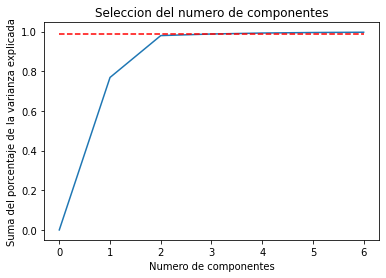

In [10]:
# Graficamos para determinar la cantidad de componentes principales
plt.plot([str(comp) for comp in comps], var_rat)
plt.title('Seleccion del numero de componentes')
plt.xlabel('Numero de componentes')
plt.ylabel('Suma del porcentaje de la varianza explicada')
plt.plot([0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99], linestyle = '--', c='r', label='99%')
plt.show()

### Implementación de análisis de componentes principales

In [11]:
# Obtenemos los componentes principales
pca = PCA(n_components=2, random_state=1)
df_pca = pca.fit_transform(x)
df_pca

array([[30.022471  , -3.98695298],
       [51.21656534, -2.09949225],
       [61.11236296, -0.58449125],
       ...,
       [35.28168917, -2.65046853],
       [11.78249488, -5.71016967],
       [-6.54788857, -5.98581035]])

In [12]:
# Varianza explicada por 2 componentes principales
sum(pca.explained_variance_ratio_)

0.9797609476690087

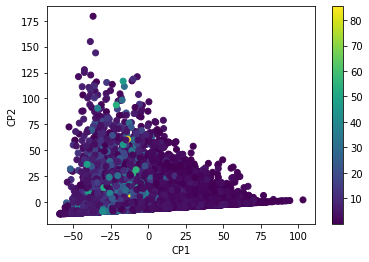

In [13]:
# Visualizamos los datos dispersos en los componentes principales
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=y)
plt.xlabel('CP1')
plt.ylabel('CP2')
plt.colorbar()

# Clustering

### K - means con todas las variables

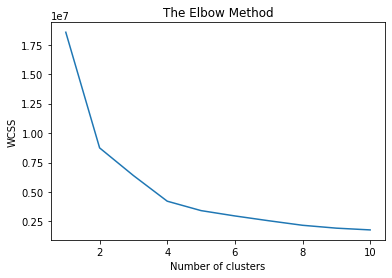

In [14]:
# Buscamos el número óptimo de clusters con todas las variables
wcss_all = []
for i in range(1, 11):
    kmns = KMeans(n_clusters=i, init='k-means++', random_state=2)
    kmns.fit(x)
    wcss_all.append(kmns.inertia_)
plt.plot(range(1, 11), wcss_all)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

> Se determina que 4 es un buen número de clusters

In [15]:
# Obtenemos clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=2)
kmeans.fit(x)

KMeans(n_clusters=4, random_state=2)

In [16]:
# Buscamos los centroides de los clusters
centers = kmeans.cluster_centers_
for i in range(4):
    print ("Centroide",i+1,": ", centers[i])

Centroide 1 :  [-1.85491874 -1.11659844  1.1901377  -0.26112145 -0.53544225  0.43155936
  0.12840839  0.96404912  1.51867014  1.22941322  1.1772857   1.22993425
  1.35677956  1.37031386  1.30672373  1.39966505  1.38010172  1.30449076]
Centroide 2 :  [-11.63251979 -11.1301891  -10.04760334 -10.75859718 -10.73342129
  -9.92451627 -10.37471417  -9.71083994  -9.1380387    0.99421724
   0.94846086   1.00969657   1.07449428   1.08863237   1.07772647
   1.15653034   1.16180739   1.12379068]
Centroide 3 :  [ 8.48631972  9.41960244 12.24732193 10.33008007 10.04925456 11.26816676
 10.74783269 11.9448095  12.79737714  1.30832413  1.22593871  1.26978189
  1.38607123  1.35063501  1.21826339  1.38440088  1.27453065  1.23800386]
Centroide 4 :  [ 3.64226415  4.47011322  7.3330566   5.37018868  5.06890567  6.26603774
  5.79064151  7.00694339  7.89471697 13.74935848 14.91109435 15.13841512
 15.78347169 16.71924527 17.02120755 16.73743395 18.75932074 17.45449058]


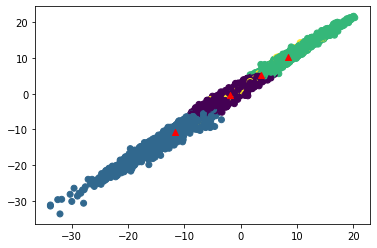

In [17]:
# Visualisamos desde cierta perspectiva
plt.scatter(x.iloc[:,0],x.iloc[:,3],c = kmeans.labels_)
plt.scatter(centers[:,0],centers[:,3],marker = '^', c = 'r')

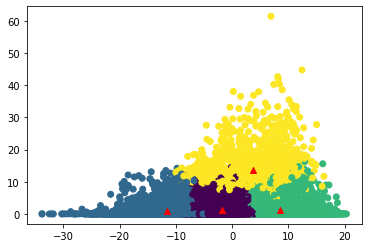

In [18]:
# Visualisamos desde cierta otra perspectiva
plt.scatter(x.iloc[:,0],x.iloc[:,9],c = kmeans.labels_)
plt.scatter(centers[:,0],centers[:,9],marker = '^', c = 'r')

### K - means con los componentes principales

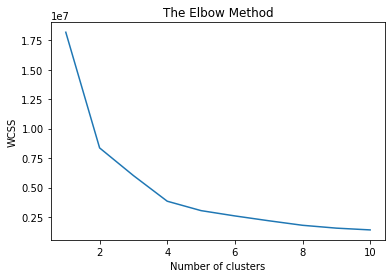

In [19]:
# Buscamos el número óptimo de clusters con todas las variables
wcss_cp = []
for i in range(1, 11):
    kms = KMeans(n_clusters=i, init='k-means++', random_state=2)
    kms.fit(df_pca)
    wcss_cp.append(kms.inertia_)
plt.plot(range(1, 11), wcss_cp)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

> Se determina que 4 es un buen número de clusters

In [20]:
# Obtenemos clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=2)
kmeans_pcs = kmeans.fit_predict(df_pca)

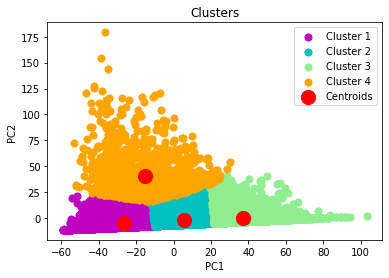

In [21]:
# Visualizamos los clusters
plt.scatter(df_pca[kmeans_pcs == 0, 0], df_pca[kmeans_pcs == 0, 1], s = 50, c = 'm', label = 'Cluster 1')
plt.scatter(df_pca[kmeans_pcs == 1, 0], df_pca[kmeans_pcs == 1, 1], s = 50, c = 'c', label = 'Cluster 2')
plt.scatter(df_pca[kmeans_pcs == 2, 0], df_pca[kmeans_pcs == 2, 1], s = 50, c = 'lightgreen', label = 'Cluster 3')
plt.scatter(df_pca[kmeans_pcs == 3, 0], df_pca[kmeans_pcs == 3, 1], s = 50, c = 'orange', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 200, c = 'r', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Observaciónes sobre el tiempo

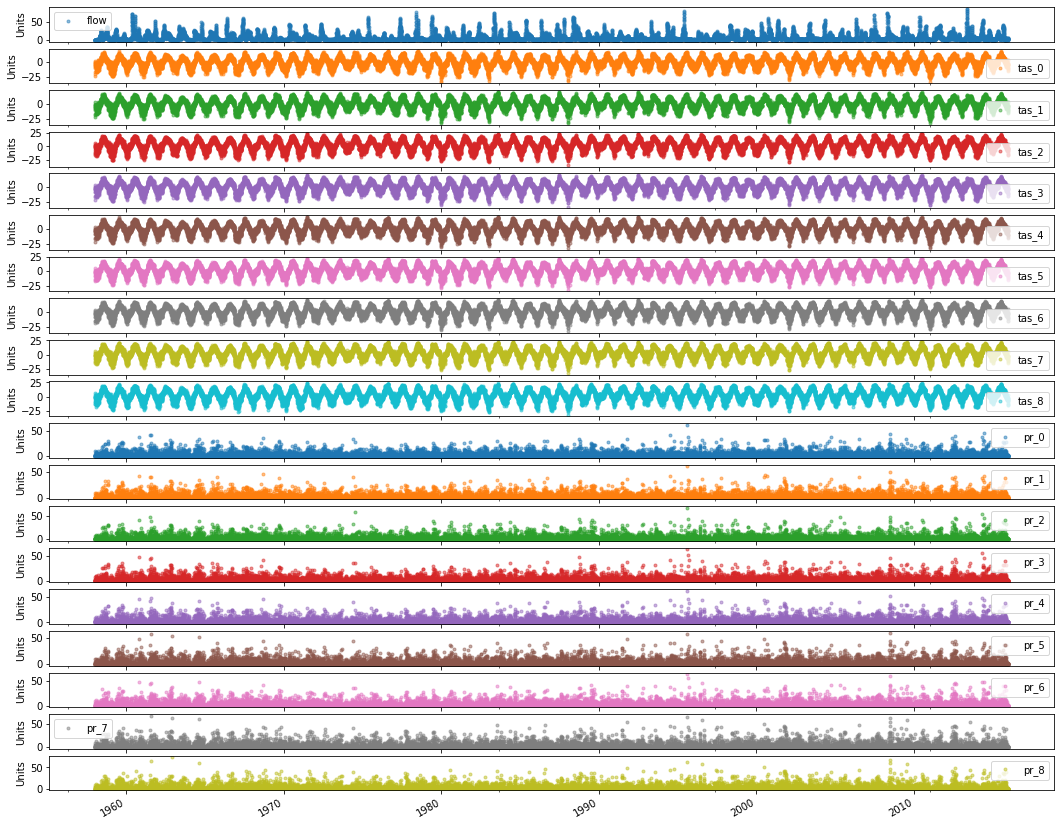

In [22]:
df2 = df.drop(['dates'], axis=1)
axes = df2.plot(marker='.', alpha=0.5, linestyle='None', figsize=(18, 16), subplots=True)
for ax in axes:
    ax.set_ylabel('Units')

In [23]:
# Separamos las variables de temperatura y presión
temp = x[['tas_0', 'tas_1', 'tas_2', 'tas_3', 'tas_4', 'tas_5', 'tas_6', 'tas_7', 'tas_8']]
pres = x[['pr_0', 'pr_1', 'pr_2', 'pr_3', 'pr_4', 'pr_5', 'pr_6', 'pr_7', 'pr_8']]

c:\users\ianti\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


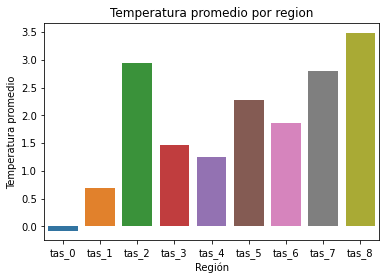

In [24]:
# Obtenemos la temperatura promedio
sns.barplot(x=temp.columns, y=np.mean(temp))
plt.title("Temperatura promedio por region")
plt.ylabel('Temperatura promedio')
plt.xlabel('Región')
plt.show()

# Análisis del último año

In [25]:
# Seleccionamos los datos del último año
df['dates'] = pd.to_datetime(df['dates'])
df['year'], df['month'] = df['dates'].dt.year, df['dates'].dt.month
df_2015 = df[df['year'] == 2015]
df_2015.head()

flow  tas_0  tas_1  tas_2  tas_3  tas_4  tas_5  tas_6  tas_7  \
2015-01-01  2.107469   -2.1   -1.3    1.4   -0.6   -0.8    0.6   -0.2    1.3   
2015-01-02  1.522931   -2.6   -1.9    0.6   -1.2   -1.4   -0.4   -0.8    0.1   
2015-01-03  0.364669   -3.2   -2.3    0.2   -1.6   -1.8   -0.7   -1.2   -0.2   
2015-01-04  2.190361   -2.3   -1.5    0.8   -0.9   -1.1    0.0   -0.5    0.7   
2015-01-05  2.729620   -3.1   -2.4    0.1   -1.6   -1.8   -0.5   -1.2    0.1   

            tas_8  ...  pr_2  pr_3       pr_4  pr_5       pr_6       pr_7  \
2015-01-01    2.7  ...   2.8   2.5   2.700000   2.7   2.100000   1.600000   
2015-01-02    1.0  ...   8.1   8.6   8.600000   7.8   7.000000   6.700000   
2015-01-03    0.6  ...   9.9   8.3   9.700000  12.1  11.100000  13.300000   
2015-01-04    1.8  ...  15.8  17.6  19.700001  18.9  20.200001  19.799999   
2015-01-05    1.2  ...   1.5   1.5   1.500000   1.1   1.100000   0.800000   

            pr_8      dates  year month  
2015-01-01   1.3 2015-01-01  2015     1  
2015-01-02   5.4 2015-01-02  2015     1  
2015-01-03  12.6 2015-01-03  2015     1  
2015-01-04  16.0 2015-01-04  2015     1  
2015-01-05   0.3 2015-01-05  2015     1  

[5 rows x 22 columns]

In [26]:
# Visualizamos los datos del último año
t1 = df_2015['tas_0']
p1 = df_2015['pr_0']
f1 = df_2015['flow']

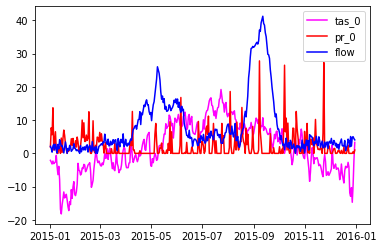

In [27]:
# Visualizamos la presión, temperatura y flujo en el último año
plt.plot(t1, color='magenta', label='tas_0', zorder=1)
plt.plot(p1, color='r', label='pr_0', zorder=1)
plt.plot(f1, color='blue', label='flow', zorder=1)
plt.legend(loc='upper right')
plt.show()

In [28]:
# Establecemos una variable dde estaciones
def s(row):
    if row['month'] == 12 or row['month'] == 1 or row['month'] == 2:
        val = 'Invierno'
    elif row['month'] == 3 or row['month'] == 4 or row['month'] == 5:
        val = 'Primavera'
    elif row['month'] == 6 or row['month'] == 7 or row['month'] == 8:
        val = 'Verano'
    else:
        val = 'Otono'
    return val

In [29]:
df_2015['Estacion'] = df_2015.apply(s, axis=1)
df_2015.head()

<ipython-input-29-677561356af4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2015['Estacion'] = df_2015.apply(s, axis=1)


flow  tas_0  tas_1  tas_2  tas_3  tas_4  tas_5  tas_6  tas_7  \
2015-01-01  2.107469   -2.1   -1.3    1.4   -0.6   -0.8    0.6   -0.2    1.3   
2015-01-02  1.522931   -2.6   -1.9    0.6   -1.2   -1.4   -0.4   -0.8    0.1   
2015-01-03  0.364669   -3.2   -2.3    0.2   -1.6   -1.8   -0.7   -1.2   -0.2   
2015-01-04  2.190361   -2.3   -1.5    0.8   -0.9   -1.1    0.0   -0.5    0.7   
2015-01-05  2.729620   -3.1   -2.4    0.1   -1.6   -1.8   -0.5   -1.2    0.1   

            tas_8  ...  pr_3       pr_4  pr_5       pr_6       pr_7  pr_8  \
2015-01-01    2.7  ...   2.5   2.700000   2.7   2.100000   1.600000   1.3   
2015-01-02    1.0  ...   8.6   8.600000   7.8   7.000000   6.700000   5.4   
2015-01-03    0.6  ...   8.3   9.700000  12.1  11.100000  13.300000  12.6   
2015-01-04    1.8  ...  17.6  19.700001  18.9  20.200001  19.799999  16.0   
2015-01-05    1.2  ...   1.5   1.500000   1.1   1.100000   0.800000   0.3   

                dates  year  month  Estacion  
2015-01-01 2015-01-01  2015      1  Invierno  
2015-01-02 2015-01-02  2015      1  Invierno  
2015-01-03 2015-01-03  2015      1  Invierno  
2015-01-04 2015-01-04  2015      1  Invierno  
2015-01-05 2015-01-05  2015      1  Invierno  

[5 rows x 23 columns]

In [30]:
# Obtenemos los datos de componentes principales del último año
pca_2015 = df_pca[-365:,:]
pca_2015 = pd.DataFrame(pca_2015, columns=['CP1', 'CP2'])
est = np.array(df_2015['Estacion'])
pca_2015['Estacion'] = est
pca_2015

CP1        CP2  Estacion
0     5.187302   0.381187  Invierno
1     6.354687  16.921909  Invierno
2     6.969182  24.514071  Invierno
3     2.652060  47.064624  Invierno
4     8.844659  -2.461504  Invierno
..         ...        ...       ...
360  40.957244  -3.245656  Invierno
361  50.391115  -2.405469  Invierno
362  35.281689  -2.650469  Invierno
363  11.782495  -5.710170  Invierno
364  -6.547889  -5.985810  Invierno

[365 rows x 3 columns]

<AxesSubplot:xlabel='CP1', ylabel='CP2'>

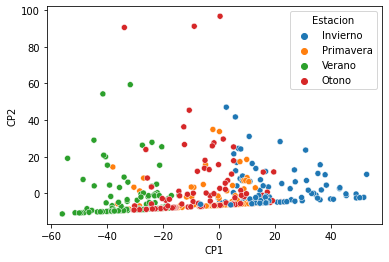

In [31]:
# Graficamos los componentes principales y le asignamos su estación correspondiente
sns.scatterplot(x=pca_2015.iloc[:,0], y=pca_2015.iloc[:,1], hue=pca_2015['Estacion'])

# Complejos Simpliciales

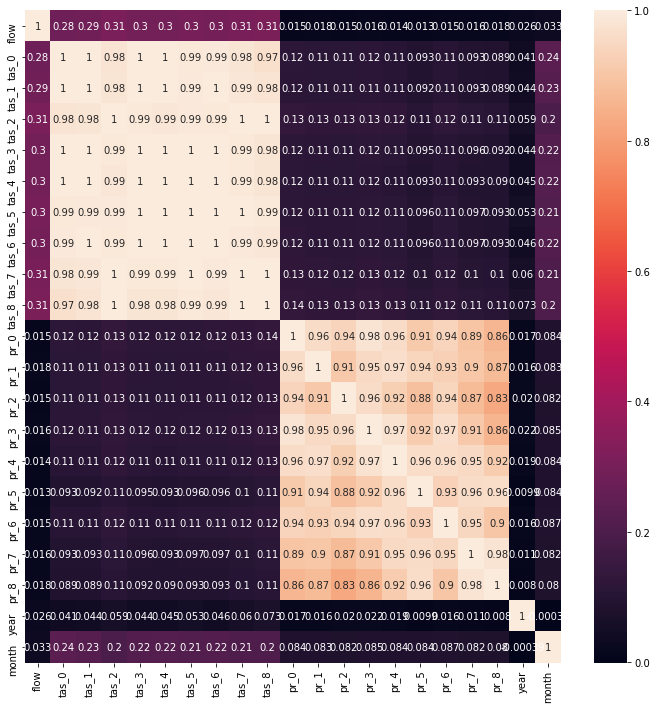

In [32]:
# Buscamos matriz de correlaciones
plt.figure(figsize=(12, 12))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

# Usamos datos del último año con PCA para buscar los complejos simpliciales

In [33]:
aux = pca_2015.iloc[:,[0,1]]
aux = aux.to_numpy()

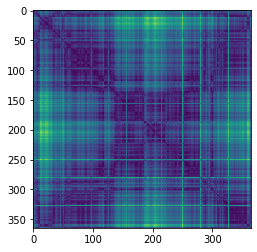

In [34]:
D = pairwise_distances(aux)
plt.imshow(D)
plt.show()

In [35]:
def create_simplicial_complex(D,r):
    """
    Input: distance matrix and nonnegative radius
    Output: networkx graph 
    """
    
    G = nx.Graph()
    G.add_nodes_from(list(range(len(D))))
    edge_list = np.argwhere(D <= r) 
    G.add_edges_from(edge_list)
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    return G

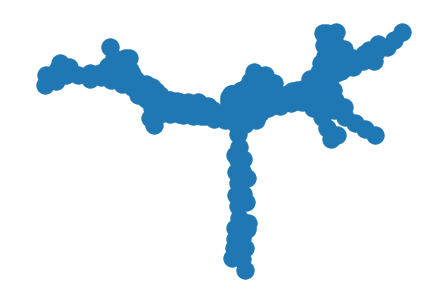

In [36]:
r = 3
G = create_simplicial_complex(D,r)
nx.draw_kamada_kawai(G)

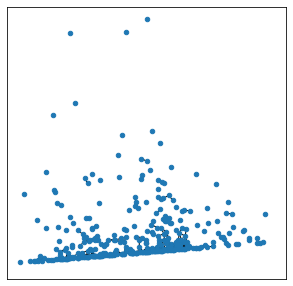

In [37]:
pos = {n:aux[n,:] for n in range(len(aux))}
plt.figure(figsize = (5,5))
nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
plt.axis('equal')
plt.show()

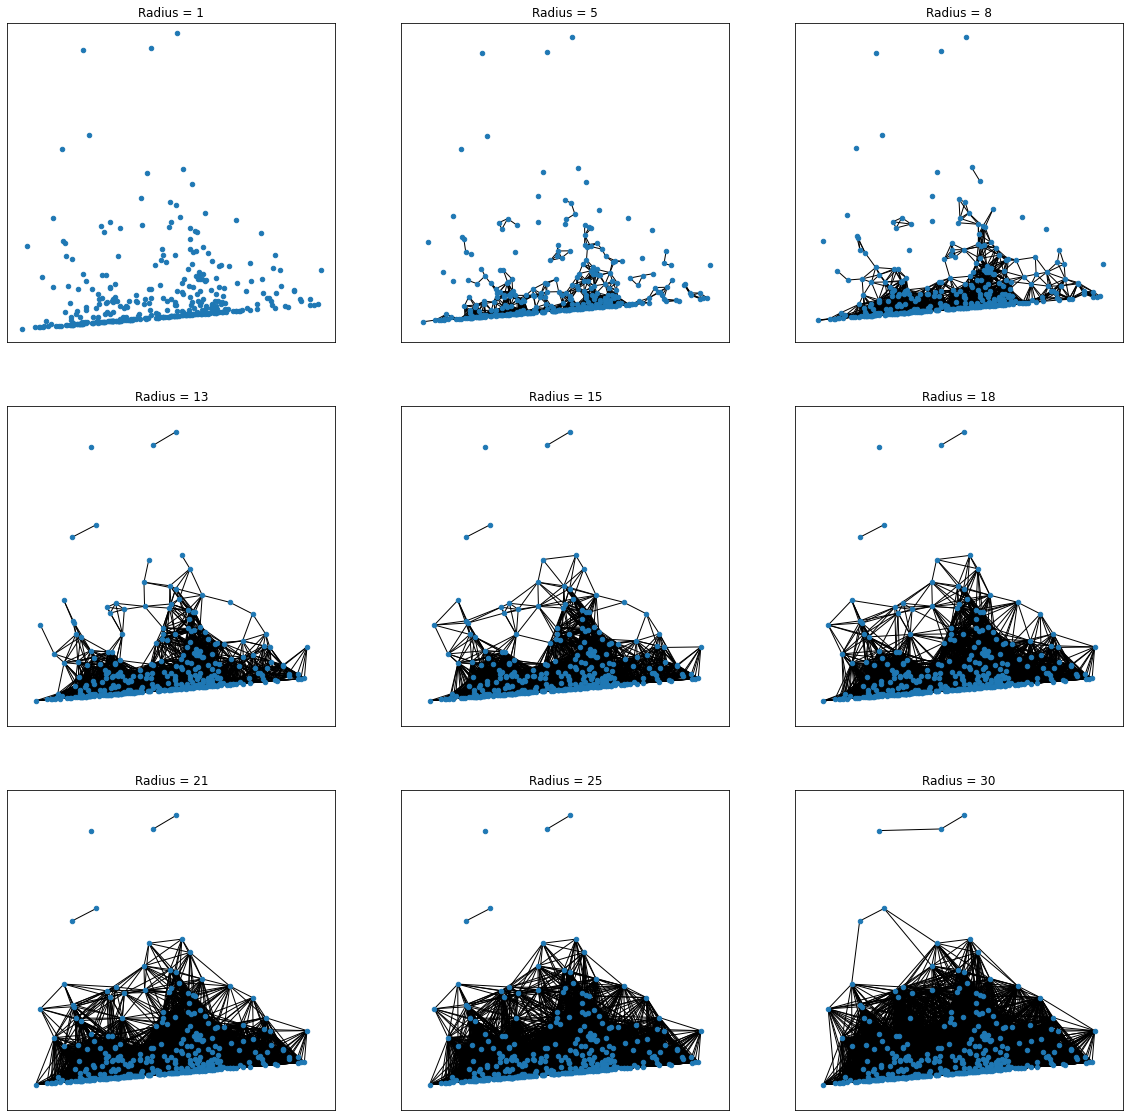

In [38]:
rs = [1,5,8,13,15,18,21,25,30]

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G = create_simplicial_complex(D,r)
    plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

# Usamos datos del último año sin PCA para buscar los complejos simpliciales

In [39]:
var_2015 = pd.DataFrame(columns=['tas_0', 'pr_0'])
var_2015['tas_0'] = t1
var_2015['pr_0'] = p1
var_2015 = var_2015.to_numpy()

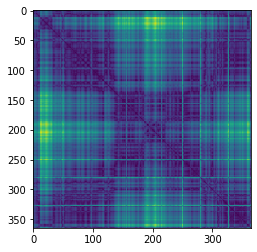

In [40]:
D = pairwise_distances(var_2015)
plt.imshow(D)
plt.show()

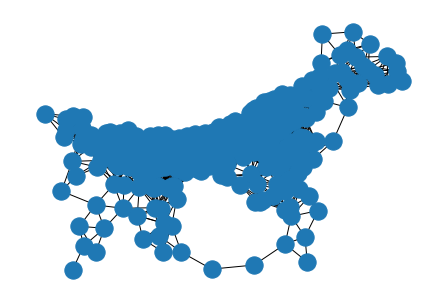

In [41]:
r = 3
G = create_simplicial_complex(D,r)
nx.draw_kamada_kawai(G)

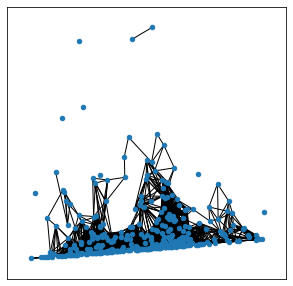

In [42]:
pos = {n:aux[n,:] for n in range(len(aux))}
plt.figure(figsize = (5,5))
nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
plt.axis('equal')
plt.show()

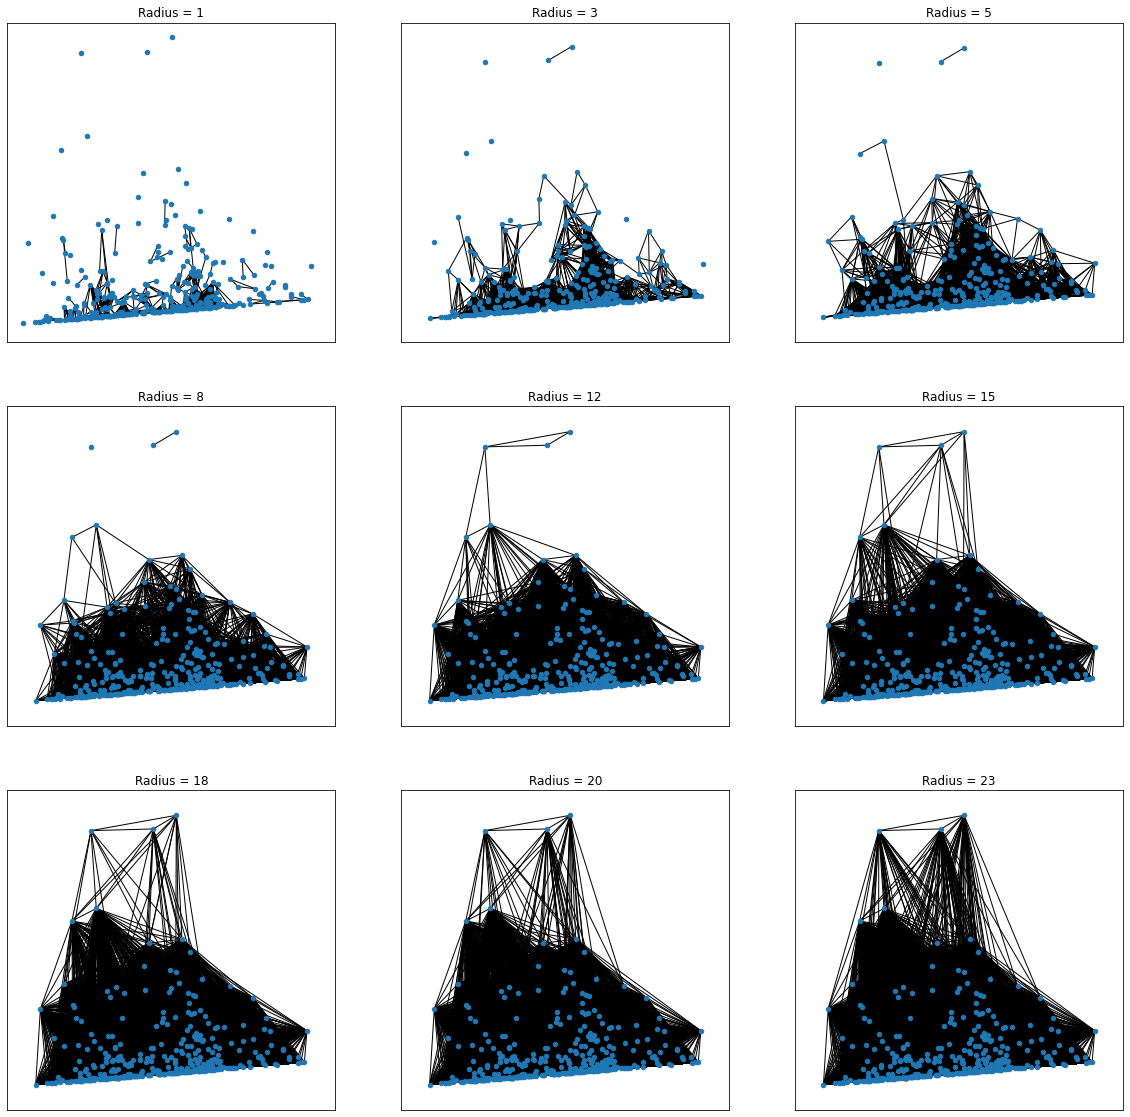

In [43]:
rs = [1,3,5,8,12,15,18,20,23]

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G = create_simplicial_complex(D,r)
    plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

# Homología Persistente

### Dragramas de Persistencia y Códigos de Barras con componentes principales

In [44]:
def visualize_persistent_homology(X, style = 'barcodes', max_dimension = 2):

    """
    In: X is a Euclidean point cloud of size [num_points,dimension]
        style = 'barcodes' or 'diagrams'
        max_dimension = highest dimensional skeleton of the VR complex to compute. Highest degree
        persistent homology will be one less than this.
    Out: plots either persistence barcodes or persistence diagrams
    """
    
    D = pairwise_distances(X)
    skeleton = gd.RipsComplex(distance_matrix = D, max_edge_length = 10) 
    Rips_complex = skeleton.create_simplex_tree(max_dimension = max_dimension)
    BarCodes = Rips_complex.persistence()

    if style == 'barcodes':
        for dim in range(max_dimension):
            print('Dimension',dim)
            plt.figure()
            gd.plot_persistence_barcode([bar for bar in BarCodes if bar[0] == dim])
            plt.show()
    elif style == 'diagrams':
        plt.figure()
        gd.plot_persistence_diagram(BarCodes)
        plt.show()
            
    return

Dimension 0


<Figure size 432x288 with 0 Axes>

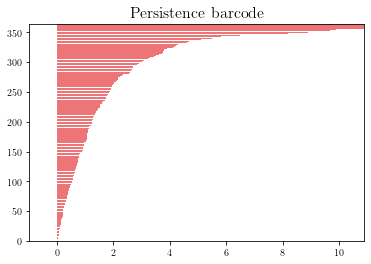

Dimension 1


<Figure size 432x288 with 0 Axes>

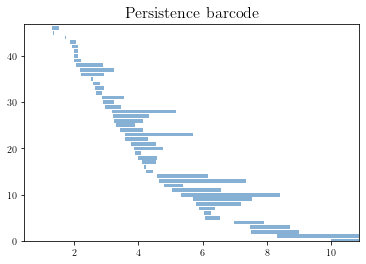

<Figure size 432x288 with 0 Axes>

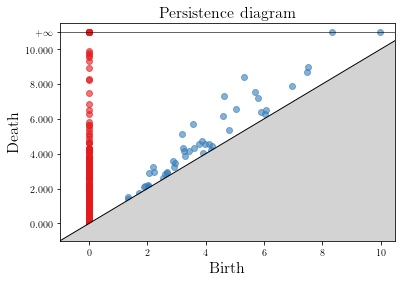

In [45]:
visualize_persistent_homology(aux)
visualize_persistent_homology(aux, style = 'diagrams')

### Dragramas de Persistencia y Códigos de Barras sin componentes principales

Dimension 0


<Figure size 432x288 with 0 Axes>

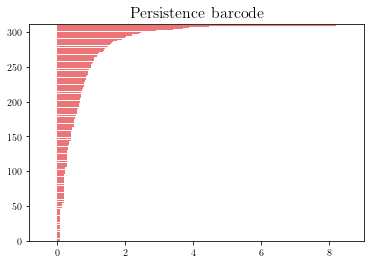

Dimension 1


<Figure size 432x288 with 0 Axes>

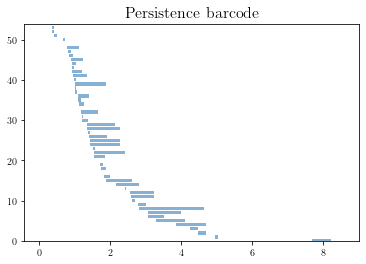

<Figure size 432x288 with 0 Axes>

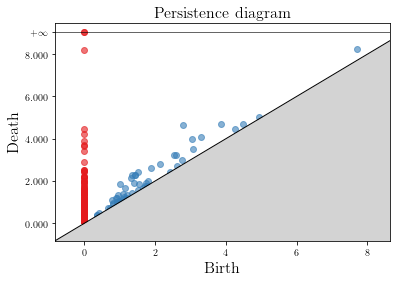

In [46]:
visualize_persistent_homology(var_2015)
visualize_persistent_homology(var_2015, style = 'diagrams')

# Topology of time series

In [47]:
cols = ['tas_0', 'pr_0']
df_time = pd.DataFrame(df[cols])
df_time

tas_0  pr_0
1958-01-04 -10.600000   0.0
1958-01-05 -20.500000   0.0
1958-01-06 -23.600000   0.1
1958-01-07 -16.200001   1.0
1958-01-08  -7.900000   9.3
...               ...   ...
2015-12-27 -10.300000   0.0
2015-12-28 -14.700000   0.0
2015-12-29  -9.500000   0.5
2015-12-30  -2.000000   0.0
2015-12-31   3.300000   1.0

[21178 rows x 2 columns]

In [48]:
embedding_dimension_periodic = 3
embedding_time_delay_periodic = 8
stride = 10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

In [49]:
# Graficamos la temperatura como una serie de tiempo periodica
y_periodic_embedded = embedder_periodic.fit_transform(var_2015[:,0])
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

Shape of embedded time series: (35, 3)


In [50]:
plot_point_cloud(y_periodic_embedded)

In [57]:
# Graficamos la presión como una serie de tiempo no periodica
embedding_dimension_nonperiodic = 3
embedding_time_delay_nonperiodic = 16
stride = 3

embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_nonperiodic,
    dimension=embedding_dimension_nonperiodic,
    stride=stride,
)

y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(var_2015[:,1])

plot_point_cloud(y_nonperiodic_embedded)